In [1]:
import pandas as pd
import numpy as np

# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from string import punctuation
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet as wn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import gensim
import spacy

In [3]:
df = pd.read_csv('train/train.csv')#, nrows=1500)

In [4]:
df.shape

(10240, 3)

In [5]:
df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [6]:
df.dtypes

Labels       int64
Text        object
Text_Tag    object
dtype: object

### Label values

Half-True - 2 
<br>False - 1
<br>Mostly-True - 3
<br>True - 5
<br>Barely-True - 0
<br>Not-Known - 4

In [44]:
label_dict = {0: "Barely True", 1: "Fake", 2: "Half True", 3: "Mostly True", 4: "Not Known", 5: "True"}

In [50]:
df['Label_Values'] = df['Labels'].apply(lambda x: label_dict[x])

In [51]:
df['Label_Values'].value_counts()

Half True      2114
Fake           1995
Mostly True    1962
True           1676
Barely True    1654
Not Known       839
Name: Label_Values, dtype: int64

<AxesSubplot:>

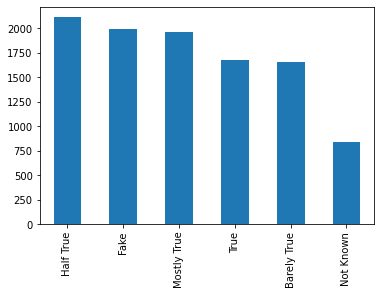

In [52]:
df['Label_Values'].value_counts().plot(kind='bar')

In [11]:
demo = df['Text'][0]
demo

'Says the Annies List political group supports third-trimester abortions on demand.'

## Tokenization

In [76]:
# [contraction_mapping[t] if t in contraction_mapping else t for t in demo.split(" ")]

In [20]:
tokens = word_tokenize(demo)
tokens

['Says',
 'the',
 'Annies',
 'List',
 'political',
 'group',
 'supports',
 'third-trimester',
 'abortions',
 'on',
 'demand',
 '.']

In [21]:
df['Clean_Text'] = df['Text'].apply(lambda x: word_tokenize(x))
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, the, Annies, List, political, group, su..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, did, the, decline, of, coal, start, ?, ..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, with, John, McCain,..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, is, likely..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, started, at, the, ..."


## Stop-words

In [22]:
stop_words = stopwords.words('english')
clean_tokens = [x for x in tokens if x not in stop_words]
clean_tokens

['Says',
 'Annies',
 'List',
 'political',
 'group',
 'supports',
 'third-trimester',
 'abortions',
 'demand',
 '.']

In [23]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [i for i in x if i not in stop_words])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, ?, It, started, n..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, ``, v..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, started, end, term..."


## Punctuation

In [24]:
clean_tokens = [x for x in clean_tokens if x not in punctuation]
clean_tokens

['Says',
 'Annies',
 'List',
 'political',
 'group',
 'supports',
 'third-trimester',
 'abortions',
 'demand']

In [25]:
punctuation += "``"

In [26]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [i for i in x if i not in punctuation])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, It, started, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, started, end, term]"


## Spelling Correction

In [27]:
from spellchecker import SpellChecker
 
spell = SpellChecker() 

In [28]:
clean_tokens = [spell.correction(x) for x in clean_tokens]
clean_tokens

['Says',
 'Annies',
 'List',
 'political',
 'group',
 'supports',
 'third-trimester',
 'abortions',
 'demand']

In [29]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [spell.correction(i) for i in x])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, It, started, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, started, end, term]"


## Lemmatization

In [30]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return wn.NOUN

In [31]:
penn_to_wn(nltk.pos_tag(['good'])[0][1])

'a'

In [32]:
lemmatizer = WordNetLemmatizer()

clean_tokens = [lemmatizer.lemmatize(x, pos=penn_to_wn(nltk.pos_tag([x])[0][1])) for x in clean_tokens]
clean_tokens

['Says',
 'Annies',
 'List',
 'political',
 'group',
 'support',
 'third-trimester',
 'abortion',
 'demand']

In [33]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [lemmatizer.lemmatize(i, pos=penn_to_wn(nltk.pos_tag([i])[0][1])) for i in x])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, It, start, natura..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, start, end, term]"


## Contraction Mapping

In [34]:
contraction_mapping = eval(open('contraction_mapping.txt','r', encoding = 'utf8').read())

In [35]:
clean_tokens = [contraction_mapping[t] if t in contraction_mapping else t for t in clean_tokens]
clean_tokens

['Says',
 'Annies',
 'List',
 'political',
 'group',
 'support',
 'third-trimester',
 'abortion',
 'demand']

In [156]:
demo2 = ["weren't", "aren't"]

In [36]:
def map_contractions(tokens, contraction_mapping):
    tokens = [contraction_mapping[t].split(" ") if t in contraction_mapping else t for t in tokens]
    final_tokens = []
    for x in tokens:
        if len(x) == 2:
            final_tokens.extend(x)
        else:
            final_tokens.append(x)
    return final_tokens    

In [37]:
map_contractions(demo2, contraction_mapping)

NameError: name 'demo2' is not defined

In [98]:
# clean_tokens

In [ ]:
clean_tokens = map_contractions(clean_tokens, contraction_mapping)
clean_tokens

In [38]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: map_contractions(x, contraction_mapping))
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, I, t, start, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, start, end, term]"


## White Spaces

In [ ]:
clean_tokens = [x.strip() for x in clean_tokens]
clean_tokens

In [39]:
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [i.strip() for i in x])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, I, t, start, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, start, end, term]"


## Lower case 

In [40]:
df['Clean_Tokens'] = df['Clean_Text'].apply(lambda x: [i.lower() for i in x])
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text,Clean_Tokens
0,1,Says the Annies List political group supports ...,abortion,False,"[Says, Annies, List, political, group, support...","[says, annies, list, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,"[When, decline, coal, start, I, t, start, natu...","[when, decline, coal, start, i, t, start, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,"[Hillary, Clinton, agrees, John, McCain, votin...","[hillary, clinton, agrees, john, mccain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,"[Health, care, reform, legislation, likely, ma...","[health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,"[The, economic, turnaround, start, end, term]","[the, economic, turnaround, start, end, term]"


In [41]:
df["Clean_Text"] = df['Clean_Tokens'].apply(lambda x: ' '.join(x))
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text,Clean_Tokens
0,1,Says the Annies List political group supports ...,abortion,False,says annies list political group support third...,"[says, annies, list, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,when decline coal start i t start natural gas ...,"[when, decline, coal, start, i, t, start, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,hillary clinton agrees john mccain voting give...,"[hillary, clinton, agrees, john, mccain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,health care reform legislation likely mandate ...,"[health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,the economic turnaround start end term,"[the, economic, turnaround, start, end, term]"


In [42]:
# df.to_pickle('clean_data.pkl')

In [81]:
# df.to_csv('clean_data.csv')

## Train Test Split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df['Clean_Text']
y = df['Labels']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

## CountVectorizer

In [26]:
count_vect = CountVectorizer(stop_words='english')

### Multinomial Naive Bayes

In [27]:
param_grid_mnb = {'vect__max_df': [0.5, 0.75, 1.0],
             'vect__max_features': [None, 5000, 10000, 50000],
             'vect__ngram_range': [(1, 1), (1, 2)],
                 'model__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [28]:
mnb = MultinomialNB()

In [29]:
pipe = Pipeline([("vect", count_vect), ("model", mnb)])

rscv = RandomizedSearchCV(pipe, param_grid_mnb, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('model', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'model__alpha': (1, 0.1, 0.01, 0.001,
                                                         0.0001, 1e-05),
                                        'vect__max_df': [0.5, 0.75, 1.0],
                                        'vect__max_features': [None, 5000,
                                                               10000, 50000],
                                        'vect__ngram_range': [(1, 1), (1, 2)]})

In [30]:
rscv.score(xtest, ytest)

0.2431640625

In [31]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5372962485406715

### Logistic Regression

In [32]:
param_grid_lr = {'vect__max_df': [0.5, 0.75, 1.0],
             'vect__max_features': [None, 5000, 10000, 50000],
             'vect__ngram_range': [(1, 1), (1, 2)],
                "model__C": np.logspace(-3,3,7), "model__penalty": ["l1","l2"]}

In [33]:
lr = LogisticRegression()

In [34]:
pipe = Pipeline([("vect", count_vect), ("model", lr)])

rscv = RandomizedSearchCV(pipe, param_grid_lr, n_jobs=-1)

rscv.fit(xtrain, ytrain)

D:\Downloads\Softwares\Anaconda\envs\tf_env\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.20935068        nan 0.23986841        nan
 0.22302209        nan        nan        nan]
  category=UserWarning


RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('model', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'model__penalty': ['l1', 'l2'],
                                        'vect__max_df': [0.5, 0.75, 1.0],
                                        'vect__max_features': [None, 5000,
                                                               10000, 50000],
                                        'vect__ngram_range': [(1, 1), (1, 2)]})

In [35]:
rscv.score(xtest, ytest)

0.23828125

In [36]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5290512431574613

### SVC

In [37]:
param_grid_svc = {'vect__max_df': [0.5, 0.75, 1.0],
             'vect__max_features': [None, 5000, 10000, 50000],
             'vect__ngram_range': [(1, 1), (1, 2)],
               'model__C': [0.1, 1, 10], 'model__gamma': [1,0.1,0.01],'model__kernel': ['rbf', 'poly', 'sigmoid']}

In [38]:
svc = SVC()

In [39]:
pipe = Pipeline([("vect", count_vect), ("model", svc)])

rscv = RandomizedSearchCV(pipe, param_grid_svc, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('model', SVC())]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.1, 1, 10],
                                        'model__gamma': [1, 0.1, 0.01],
                                        'model__kernel': ['rbf', 'poly',
                                                          'sigmoid'],
                                        'vect__max_df': [0.5, 0.75, 1.0],
                                        'vect__max_features': [None, 5000,
                                                               10000, 50000],
                                        'vect__ngram_range': [(1, 1), (1, 2)]})

In [40]:
rscv.score(xtest, ytest)

0.2236328125

In [41]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5117262095714475

### Decision Trees

In [42]:
param_grid_dt = {'vect__max_df': [0.5, 0.75, 1.0],
             'vect__max_features': [None, 5000, 10000, 50000],
             'vect__ngram_range': [(1, 1), (1, 2)],
             'model__criterion': ['gini','entropy'],'model__max_depth':[5, 10, 20, 50, 100]}

In [43]:
dt = DecisionTreeClassifier()

In [44]:
pipe = Pipeline([("vect", count_vect), ("model", dt)])

rscv = RandomizedSearchCV(pipe, param_grid_dt, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 20, 50,
                                                             100],
                                        'vect__max_df': [0.5, 0.75, 1.0],
                                        'vect__max_features': [None, 5000,
                                                               10000, 50000],
                                        'vect__ngram_range': [(1, 1), (1, 2)]})

In [45]:
rscv.score(xtest, ytest)

0.24267578125

In [46]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5295673049427163

## RandomForest

In [47]:
param_grid_rf = {'vect__max_df': [0.5, 0.75, 1.0],
             'vect__max_features': [None, 5000, 10000, 50000],
             'vect__ngram_range': [(1, 1), (1, 2)],
                 'model__min_samples_leaf': [1, 2, 4], 'model__min_samples_split': [2, 5, 10],
             'model__criterion': ['gini','entropy'],'model__max_depth':[5, 10, 20, 50, 100],
                 'model__n_estimators': [200, 400, 1000]}

In [50]:
rf = RandomForestClassifier()

In [51]:
pipe = Pipeline([("vect", count_vect), ("model", rf)])

rscv = RandomizedSearchCV(pipe, param_grid_rf, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(stop_words='english')),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 20, 50,
                                                             100],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 1000],
                                        'vect__max_df': [0.5, 0.75, 1.0],
                                        'vect__max_features': [None, 5000,
                                                               10000, 50000],
          

In [52]:
rscv.score(xtest, ytest)

0.2509765625

In [53]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5308446387583693

## Tf-IDF

In [33]:
tfidf = TfidfVectorizer()

### Multinomial Naive Bayes

In [34]:
param_grid_mnb = {'tfidf__use_idf': (True, False),
                  'tfidf__norm': ('l1', 'l2'),
                 'model__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [35]:
mnb = MultinomialNB()

In [36]:
pipe = Pipeline([("tfidf", tfidf), ("model", mnb)])

rscv = RandomizedSearchCV(pipe, param_grid_mnb, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'model__alpha': (1, 0.1, 0.01, 0.001,
                                                         0.0001, 1e-05),
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [37]:
rscv.score(xtest, ytest)

0.23486328125

In [44]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5206326900227343

### Logistic Regression

In [45]:
param_grid_lr = {'tfidf__use_idf': (True, False),
                  'tfidf__norm': ('l1', 'l2'),
                "model__C": [0.001, 0.01, 0.1, 1.0], "model__penalty": ["l1","l2"]}

In [46]:
lr = LogisticRegression()

In [47]:
pipe = Pipeline([("tfidf", tfidf), ("model", lr)])

rscv = RandomizedSearchCV(pipe, param_grid_lr, n_jobs=-1)

rscv.fit(xtrain, ytrain)

D:\Downloads\Softwares\Anaconda\envs\tf_env\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.23596418 0.20727535        nan 0.23828394 0.20727535        nan
        nan 0.23559788        nan        nan]
  category=UserWarning
D:\Downloads\Softwares\Anaconda\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1.0],
                                        'model__penalty': ['l1', 'l2'],
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [48]:
rscv.score(xtest, ytest)

0.25390625

In [49]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5326040022226347

### SVC

In [50]:
param_grid_svc = {'tfidf__use_idf': (True, False),
                  'tfidf__norm': ('l1', 'l2'),
               'model__C': [0.1, 1, 10], 'model__gamma': [1,0.1,0.01],'model__kernel': ['rbf', 'poly', 'sigmoid']}

In [51]:
svc = SVC()

In [52]:
pipe = Pipeline([("tfidf", tfidf), ("model", svc)])

rscv = RandomizedSearchCV(pipe, param_grid_svc, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model', SVC())]),
                   n_jobs=-1,
                   param_distributions={'model__C': [0.1, 1, 10],
                                        'model__gamma': [1, 0.1, 0.01],
                                        'model__kernel': ['rbf', 'poly',
                                                          'sigmoid'],
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [53]:
rscv.score(xtest, ytest)

0.24658203125

In [54]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5361902877214778

### Decision Trees

In [55]:
param_grid_dt = {'tfidf__use_idf': (True, False),
                  'tfidf__norm': ('l1', 'l2'),
             'model__criterion': ['gini','entropy'],'model__max_depth':[5, 10, 20, 50, 100]}

In [56]:
dt = DecisionTreeClassifier()

In [57]:
pipe = Pipeline([("tfidf", tfidf), ("model", dt)])

rscv = RandomizedSearchCV(pipe, param_grid_dt, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 20, 50,
                                                             100],
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [58]:
rscv.score(xtest, ytest)

0.22705078125

In [59]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5174142834309677

## RandomForest

In [65]:
param_grid_rf = {'tfidf__use_idf': (True, False),
                  'tfidf__norm': ('l1', 'l2'), 'model__min_samples_leaf': [1, 2, 4], 'model__min_samples_split': [2, 5, 10],
             'model__criterion': ['gini','entropy'],'model__max_depth':[5, 10, 20, 50, 100],
                 'model__n_estimators': [200, 400, 1000]}

In [66]:
rf = RandomForestClassifier()

In [67]:
pipe = Pipeline([("tfidf", tfidf), ("model", rf)])

rscv = RandomizedSearchCV(pipe, param_grid_rf, n_jobs=-1)

rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [5, 10, 20, 50,
                                                             100],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 1000],
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)})

In [68]:
rscv.score(xtest, ytest)

0.2646484375

In [69]:
ypred = rscv.predict(xtest)
ypred2 = keras.utils.to_categorical(ypred, num_classes=6, dtype='float32')
ytest2 = keras.utils.to_categorical(ytest, num_classes=6, dtype='float32')

roc_auc_score(ytest2, ypred2, multi_class='ovr')

0.5405678089617703

## Ideas

- Word Clouds for True and Fake news
- Topic Modelling using LDA

In [222]:
df = pd.read_pickle('clean_data.pkl')

In [223]:
df.head()

,Labels,Text,Text_Tag,Label_Values,Clean_Text,Clean_Tokens
0,1,Says the Annies List political group supports ...,abortion,False,says annies list political group support third...,"[says, annies, list, political, group, support..."
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Half True,when decline coal start i t start natural gas ...,"[when, decline, coal, start, i, t, start, natu..."
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Mostly True,hillary clinton agrees john mccain voting give...,"[hillary, clinton, agrees, john, mccain, votin..."
3,1,Health care reform legislation is likely to ma...,health-care,False,health care reform legislation likely mandate ...,"[health, care, reform, legislation, likely, ma..."
4,2,The economic turnaround started at the end of ...,"economy,jobs",Half True,the economic turnaround start end term,"[the, economic, turnaround, start, end, term]"


# Neural Network

In [6]:
# !pip install pandas==1.1.5

  Using cached pandas-1.1.5-cp36-cp36m-win_amd64.whl (8.7 MB)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.shape

(10240, 7)

In [4]:
train_df = df.iloc[:-1000, :]
test_df = df.iloc[-1000:, :]

In [5]:
target = train_df['Labels'].values
# target = df['Labels'].values

In [6]:
labels_encoded = keras.utils.to_categorical(target, num_classes=6, dtype='float32')

In [7]:
labels_encoded

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [8]:
# tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
# tokenizer.fit_on_texts(df['Clean_Text'])

# max_length = 25
# vocab_size = 6000

# sequences_train = tokenizer.texts_to_sequences(df['Clean_Text'])
# # sequences_test = tokenizer.texts_to_sequences(test_df['Text'])

# padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
# # padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

# xtrain, xtest, ytrain, ytest = tts(padded_train, labels_encoded, test_size=0.2)

# print(xtrain.shape)
# print(ytrain.shape)

(8192, 25)
(8192, 6)


In [9]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(train_df['Clean_Text'])

max_length = 20
vocab_size = 6000

sequences_train = tokenizer.texts_to_sequences(train_df['Clean_Text'])
sequences_test = tokenizer.texts_to_sequences(test_df['Clean_Text'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

xtrain, xtest, ytrain, ytest = tts(padded_train, labels_encoded, test_size=0.2)

print(xtrain.shape)
print(ytrain.shape)

(7392, 20)
(7392, 6)


## GloVe embeddings

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [10]:
f = open('glove/glove.6B.300d.txt', encoding="utf8")

embeddings_index = dict()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {} word vectors.'.format(len(embeddings_index)))

Loaded 400000 word vectors.


In [11]:
# create a weight matrix for words in training docs
print('Get vocab_size')
vocab_size = len(tokenizer.word_index) + 1

print('Create the embedding matrix')
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Get vocab_size
Create the embedding matrix


## Simple Neural Network

In [12]:
best_model_file_name = "models/simple_model.hdf5"

In [18]:
callbacks=[  keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1,   save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')]

In [14]:
ytrain

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
model = Sequential()

model.add(Embedding(vocab_size, 
                    300, 
                    weights=[embedding_matrix], 
                    input_length=max_length,
                    trainable=False))


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
#Output
model.add(Dense(6, activation='sigmoid'))




In [173]:
# Model
from model import SentimentNet
from keras.optimizers import Adam

model = SentimentNet(max_length, vocab_size, 300, num_classes = 6)
model = model.forward()

model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

model.layers[-1].activation = keras.activations.sigmoid

opt = Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.05)
model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [132]:
# model = Sequential()
# model.add(Embedding(vocab_size, 10, input_length=max_length))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(6, activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           2804700   
_________________________________________________________________
dense_1 (Dense)              (None, 20, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 128)           8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])

In [22]:
history = model.fit(xtrain, 
                    ytrain, 
                    epochs=50, 
                    batch_size = 64,
                    validation_data=(xtest, ytest), 
                    callbacks=callbacks,
                   shuffle = True)

Train on 7392 samples, validate on 1848 samples
Epoch 1/50
7392/7392 [==============================] - 4s 485us/step - loss: 0.4626 - precision_1: 0.1769 - recall_1: 0.0093 - accuracy: 0.8277 - val_loss: 0.4545 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.45451, saving model to models/simple_model.hdf5
Epoch 2/50
7392/7392 [==============================] - 1s 69us/step - loss: 0.4417 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.8333 - val_loss: 0.4518 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.8332

Epoch 00002: val_loss improved from 0.45451 to 0.45175, saving model to models/simple_model.hdf5
Epoch 3/50
7392/7392 [==============================] - 1s 74us/step - loss: 0.4377 - precision_1: 0.5238 - recall_1: 0.0015 - accuracy: 0.8334 - val_loss: 0.4504 - val_precision_1: 0.5000 - val_recall_1: 5.4113e-04 - val_accuracy: 0.8333

Epoch 00003: val_loss imp

In [15]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score

In [18]:
# ypred = np.argmax(ypred, 1)

In [17]:
ypred = (model.predict(xtest)).astype("float32")
ypred2 = np.argmax(ypred, 1)
ytest2 = np.argmax(ytest, 1)
print('Classification Report: ', classification_report(ytest2, ypred2))

NameError: name 'model' is not defined

In [16]:
print(roc_auc_score(ytest, ypred, multi_class='ovr'))

NameError: name 'ypred' is not defined

In [28]:
print(np.round(accuracy_score(ytest2, ypred2), 4))

0.2222


In [21]:
print(np.round(f1_score(ytest2, ypred2, average='weighted'), 4))

0.2094


## Test set evaluation

In [23]:
ypred = (model.predict(padded_test)).astype("float32")
ypred2 = np.argmax(ypred, 1)
# ytest2 = np.argmax(ytest, 1)
print('Classification Report: ', classification_report(test_df['Labels'], ypred2))

Classification Report:                precision    recall  f1-score   support

           0       0.21      0.15      0.18       151
           1       0.29      0.48      0.37       211
           2       0.22      0.17      0.19       203
           3       0.27      0.46      0.34       184
           4       1.00      0.01      0.02        89
           5       0.24      0.10      0.15       162

    accuracy                           0.26      1000
   macro avg       0.37      0.23      0.21      1000
weighted avg       0.32      0.26      0.23      1000



In [24]:
ytest2 = keras.utils.to_categorical(test_df['Labels'], num_classes=6, dtype='float32')
print(roc_auc_score(ytest2, ypred, multi_class='ovr'))

0.6109925378268929


In [63]:
ypred = (model.predict(padded_test)).astype("float32")
ytest2 = keras.utils.to_categorical(test_df['Labels'], num_classes=6, dtype='float32')
print(np.round(roc_auc_score(ytest2, ypred, multi_class='ovr'), 4))

0.577


In [28]:
print(np.round(accuracy_score(ytest2, ypred2), 4))

0.2222


In [21]:
print(np.round(f1_score(ytest2, ypred2, average='weighted'), 4))

0.2094


In [46]:
def detect_fake_news(text):
    text = [text]
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, padding = 'post', maxlen=max_length)
    prediction = label_dict[np.argmax(model.predict(text), 1)[0]]
    print('The given news article is: ', prediction)

In [49]:
detect_fake_news("ISIS set the Eiffel Tower on fire")

The given news article is:  Fake


In [47]:
detect_fake_news("Woman murders roommate for sending thousands of candy crush requests")

The given news article is:  Fake


In [45]:
testA = ["Woman murders roommate for sending thousands of candy crush requests"]
testA = tokenizer.texts_to_sequences(testA)
testA = pad_sequences(testA, padding = 'post', maxlen=max_length)
prediction = label_dict[np.argmax(model.predict(testA), 1)[0]]
print('The given news article is: ', prediction)

The given news article is:  Fake


In [ ]:
testB = "Harambe receives thousands of votes in the US election"
testB = tokenizer.texts_to_sequences(testB)
testB = pad_sequences(testB, padding = 'post', maxlen=max_length)

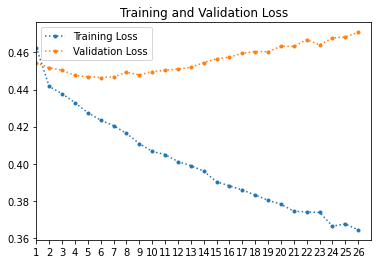

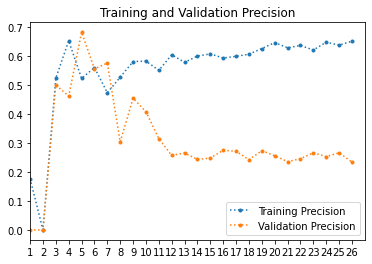

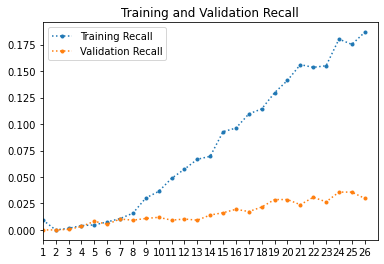

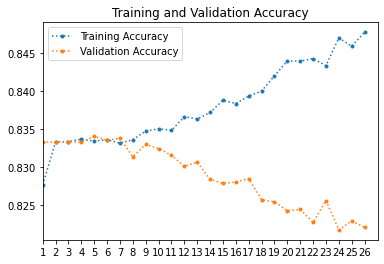

In [29]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training Loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

# plot training and validation precision

metric_to_plot = "precision_1"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training Precision")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation Precision")
plt.title('Training and Validation Precision')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

# plot training and validation recall

metric_to_plot = "recall_1"

plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training Recall")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation Recall")
plt.title('Training and Validation Recall')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

metric_to_plot = "accuracy"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training Accuracy")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [26]:
history.history.keys()

dict_keys(['val_loss', 'val_precision_1', 'val_recall_1', 'val_accuracy', 'loss', 'precision_1', 'recall_1', 'accuracy'])

# Topic Modelling using LDA

In [5]:
df = pd.read_pickle('clean_data.pkl')

### Create a Dictionary

In [21]:
df['Clean_Tokens'] = df['Clean_Tokens'].apply(lambda x: [i for i in x if len(i) > 2])

In [22]:
dictionary = Dictionary(df['Clean_Tokens'])

### Filter low-frequency words

In [23]:
dictionary.filter_extremes(no_below=10, no_above=0.5)

### Create Corpus

In [24]:
tokens = df['Clean_Tokens'].values

In [25]:
corpus = [dictionary.doc2bow(text) for text in tokens]

In [26]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 3),
  (17, 1),
  (18, 1)],
 [(9, 1),
  (13, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(16, 1), (36, 1), (37, 1), (38, 1), (39, 1)],
 [(16, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1)],
 [(48, 1), (49, 1), (50, 1), (51, 1), (52, 1)],
 [(34, 1),
  (43, 1),
  (48, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1)],
 [(17, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)],
 [(5, 1),
  (65, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1)],
 [(76, 2),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1

### Create Index 2 word dictionary

In [27]:
temp = dictionary[0]
id2word = dictionary.id2token

In [28]:
id2word

{0: 'abortion',
 1: 'demand',
 2: 'group',
 3: 'list',
 4: 'political',
 5: 'says',
 6: 'support',
 7: 'administration',
 8: 'begin',
 9: 'bush',
 10: 'coal',
 11: 'decline',
 12: 'gas',
 13: 'george',
 14: 'natural',
 15: 'president',
 16: 'start',
 17: 'take',
 18: 'when',
 19: 'benefit',
 20: 'clinton',
 21: 'give',
 22: 'hillary',
 23: 'iran',
 24: 'john',
 25: 'mccain',
 26: 'voting',
 27: 'care',
 28: 'change',
 29: 'free',
 30: 'health',
 31: 'legislation',
 32: 'likely',
 33: 'mandate',
 34: 'reform',
 35: 'sex',
 36: 'economic',
 37: 'end',
 38: 'term',
 39: 'the',
 40: 'chicago',
 41: 'decade',
 42: 'fire',
 43: 'last',
 44: 'number',
 45: 'tenure',
 46: 'total',
 47: 'two',
 48: 'year',
 49: 'district',
 50: 'jim',
 51: 'live',
 52: 'represent',
 53: 'along',
 54: 'ethic',
 55: 'passing',
 56: 'person',
 57: 'reinhold',
 58: 'russ',
 59: 'since',
 60: 'stage',
 61: 'work',
 62: 'fund',
 63: 'land',
 64: 'lottery',
 65: 'million',
 66: 'new',
 67: 'oregon',
 68: 'cast',
 69: 

### Build a News Topic Model

#### LdaModel
- **num_topics** : this is the number of topics you need to define beforehand
- **chunksize** : the number of documents to be used in each training chunk
- **alpha** : this is the hyperparameters that affect the sparsity of the topics
- **passess** : total number of training assess

In [30]:
ldamodel = LdaModel(corpus, num_topics=5, id2word = id2word, passes=20)

### Print the Keyword in the 10 topics

In [31]:
pprint(ldamodel.print_topics(num_topics=5, num_words=10))

[(0,
  '0.033*"year" + 0.026*"job" + 0.023*"state" + 0.018*"percent" + '
  '0.018*"million" + 0.017*"the" + 0.012*"every" + 0.011*"people" + '
  '0.010*"get" + 0.010*"school"'),
 (1,
  '0.062*"tax" + 0.048*"says" + 0.026*"cut" + 0.019*"billion" + 0.018*"budget" '
  '+ 0.018*"pay" + 0.016*"would" + 0.014*"state" + 0.013*"raise" + '
  '0.012*"scott"'),
 (2,
  '0.038*"obama" + 0.034*"percent" + 0.025*"president" + 0.021*"the" + '
  '0.017*"barack" + 0.016*"rate" + 0.016*"high" + 0.015*"says" + '
  '0.015*"united" + 0.015*"states"'),
 (3,
  '0.031*"health" + 0.028*"care" + 0.028*"says" + 0.024*"say" + 0.018*"bill" + '
  '0.014*"law" + 0.013*"the" + 0.012*"insurance" + 0.011*"government" + '
  '0.011*"senate"'),
 (4,
  '0.028*"says" + 0.023*"vote" + 0.014*"state" + 0.012*"republican" + '
  '0.012*"voter" + 0.011*"party" + 0.010*"the" + 0.010*"illegal" + '
  '0.009*"campaign" + 0.009*"even"')]


In [32]:
from gensim.models.coherencemodel import CoherenceModel

In [33]:
cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
pprint(coherence)

-4.155886467816474


### Visualize the Topic Model
- Use **pyLDAvis**
    - designed to help users **interpret the topics** in a topic model that has been fit to a corpus of text data
    - extracts information from a fitted LDA topic model to inform an interactive web-based visualization

In [34]:
import pyLDAvis.gensim_models

In [35]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

d:\downloads\softwares\anaconda\envs\ml-venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.179749  0.033038       1        1  23.998823
2     -0.251954 -0.102574       2        1  21.116484
3      0.218839 -0.066532       3        1  19.512317
1      0.150394 -0.157473       4        1  18.813629
4      0.062470  0.293542       5        1  16.558747, topic_info=       Term         Freq        Total Category  logprob  loglift
152     tax  1082.000000  1082.000000  Default  30.0000  30.0000
209   obama   784.000000   784.000000  Default  29.0000  29.0000
30   health   567.000000   567.000000  Default  28.0000  28.0000
27     care   509.000000   509.000000  Default  27.0000  27.0000
329     job   583.000000   583.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
110     ...   110.625129   367.312790   Topic5  -4.9302   0.5982
263     one   106.322486   414.662152   Topic5  -4.9699   0.4373
254     law   103.689280   385.724522   Topic5  -4.9949   0.4845
163     get   100.652674   482.100822   Topic5  -5.0247   0.2318
289     use    91.199200   198.724447   Topic5  -5.1233   1.0194

[291 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
110       1  0.277692    ...
110       2  0.089842    ...
110       3  0.209631    ...
110       4  0.119789    ...
110       5  0.302195    ...
...     ...       ...    ...
432       2  0.992801  wrist
685       3  0.981573  write
48        1  0.670938   year
48        2  0.238311   year
48        4  0.090742   year

[391 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

# Word Clouds

In [70]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [71]:
stop_words = stopwords.words('english')

In [72]:
text = " ".join(review for review in df['Clean_Text'])

In [73]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

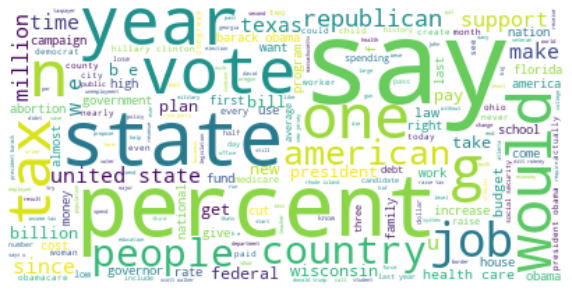

In [33]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud for True news

In [39]:
df[df['Label_Values'] == 'True']['Clean_Text']

5       the chicago bears start quarterback last 1 0 y...
16      mccain oppose requirement government buy ameri...
30                     says paul ryan still endorse trump
35      w e federal government think authority regulat...
36      austin city basically double size every 2 5 ye...
                              ...                        
1471    w e recognize salary faculty low new england e...
1476                preventive care save government money
1479    says abraham lincoln try buy slavesfreedom bor...
1485    says rick scott didnt even come education summ...
1491                                  i support sequester
Name: Clean_Text, Length: 244, dtype: object

In [89]:
text = " ".join(review for review in df[df['Label_Values'] == 'True']['Clean_Text'])

In [90]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

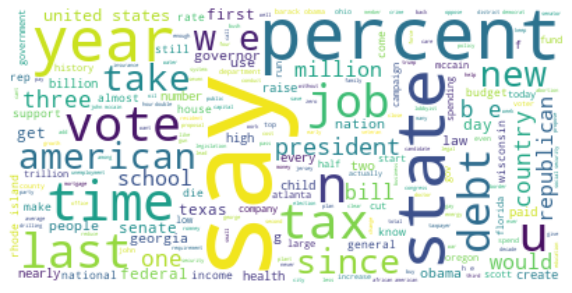

In [37]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [109]:
mask = np.array(Image.open("true2.png"))

In [110]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [111]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [112]:
transformed_mask = np.ndarray((mask.shape[0], mask.shape[1]), np.int32)

In [113]:
for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))

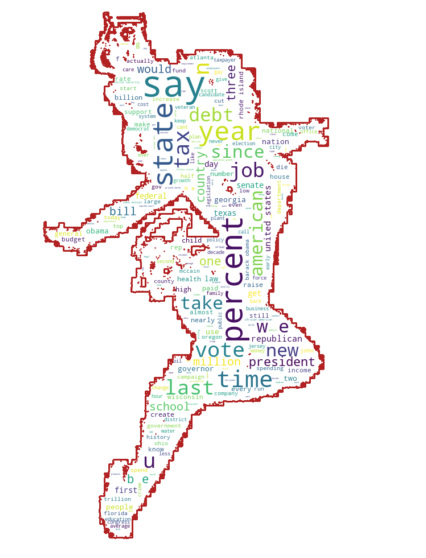

In [99]:
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

wc.generate(text)

# wc.to_file("true2.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
mask = np.array(Image.open("truth3.jpg"))

transformed_mask = np.ndarray((mask.shape[0], mask.shape[1]), np.int32)

for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))
    
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

wc.generate(text)

# wc.to_file("true2.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Word Cloud for False news

In [76]:
text = " ".join(review for review in df[df['Label_Values'] == 'False']['Clean_Text'])

In [77]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

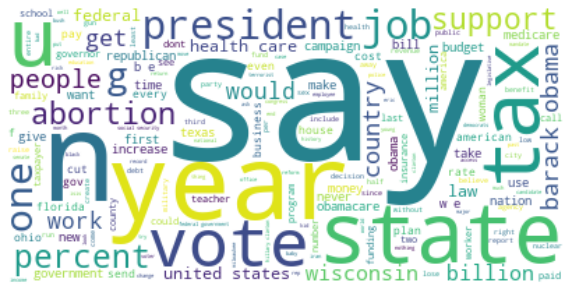

In [42]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [83]:
mask = np.array(Image.open("fake4.jpg"))

In [84]:
mask[0]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

In [85]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [86]:
transformed_mask = np.ndarray((mask.shape[0], mask.shape[1]), np.int32)

In [87]:
for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))

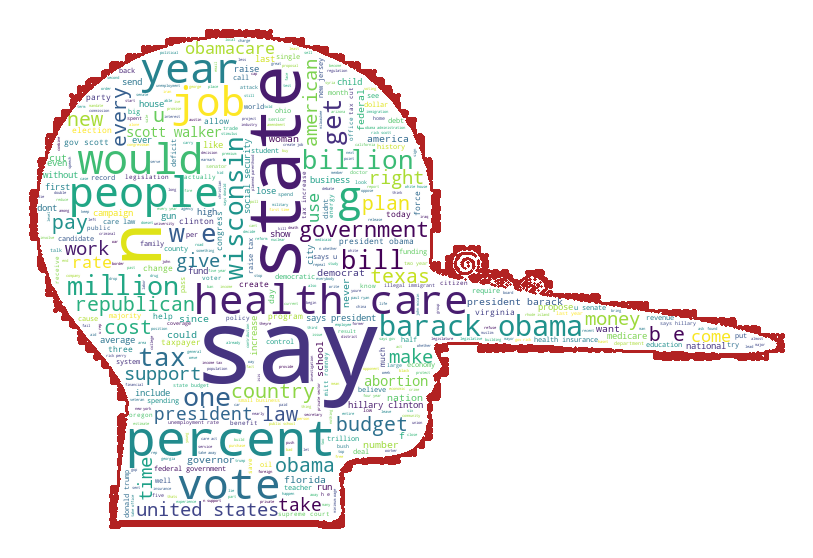

In [88]:
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

wc.generate(text)

# wc.to_file("true2.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask,
               stopwords=stop_words, contour_width=3, contour_color='firebrick')

wc.generate(text)

# wc.to_file("true2.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()